## 1. pytorch - LSTM introduction

<img src="image/pytorch_LSTM_1.png" width="550">

### 1.1 LSTM architecture：
> **model = nn.LSTM(input_size, hidden_size, num_layers, bias, batch_first, dropout, bidirectional)**
1. input_size: 每个单词的 embedding or one-hot encoding 的尺寸，例如：glove 300d。
2. hidden_size: 隐含层神经元的个数，例如上图的n。
3. num_layers: LSTM的层数，例如上图的层数为1。
4. bias: default true。
5. batch_first: 
6. dropout: 0-1
7. bidirectional: true or false.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

lstm = nn.LSTM(100, 3, 2)  # word embedding size is 300, hidden layer size is 3, two LSTM layer. 
print(lstm.all_weights[0][0].shape)
print(lstm.all_weights[0][1].shape)
print(lstm.all_weights[0][2].shape)
print(lstm.all_weights[0][3].shape)

torch.Size([12, 100])
torch.Size([12, 3])
torch.Size([12])
torch.Size([12])


### 1.2 LSTM input and output：
><img src="image/pytorch_LSTM.png" width="500">
>
>**output, ($\text{h}_n$, $\text{c}_n$) = model(input, ($\text{h}_0$, $\text{c}_0$))**
>
>* input维度：(句子长度, batch_size（一次多少个句子）, input_size（每个单词向量的长度）) 。
>* $\text{h}_0, \text{c}_0$维度：(num_layers * num_directions, batch, hidden_size)。例如，上图有w+1层，单向，hidden_size为每个LSTM结构内隐含层神经元个数。 


In [2]:
inputs = [torch.randn(1, 100) for _ in range(5)] # In a sentence, 5 words, every words' length is 4.

hidden = (torch.randn(2*1, 1, 3), torch.randn(2*1, 1, 3)) # h_0, c_0.

for i in inputs:
    out, hidden = lstm(i.view(1, 1, -1), hidden)

print("1. sentence length: ",len(inputs)," word embedding:",inputs[0].shape)
print("2. input is every word in sentence: ", i.view(1, 1, -1).shape)
print("3. output size: ", out.shape)
print("4. h_1 size: ", hidden[0].shape)
print("5. c_1 size: ", hidden[1].shape)

1. sentence length:  5  word embedding: torch.Size([1, 100])
2. input is every word in sentence:  torch.Size([1, 1, 100])
3. output size:  torch.Size([1, 1, 3])
4. h_1 size:  torch.Size([2, 1, 3])
5. c_1 size:  torch.Size([2, 1, 3])


### 1.3 forward pass

**module(data) = module.forward(data)**

<img src="image/forward.png" width="550">

### 1.4 handle input with variable length

https://blog.csdn.net/kejizuiqianfang/article/details/100835528

* torch.nn.utils.rnn.pad_sequence()：把不等长的tensor数据, 补充成等长的tensor数据.
* torch.nn.utils.rnn.pack_padded_sequence()：把等长的tensor根据所输入的参数压缩成实际的数据, 同时数据格式变成PackedSequence。
* torch.nn.utils.rnn.pad_packed_sequence()：把上面所压缩成PackedSequence的数据还原成tensor类型, 并补成等长的数据。


## 2. bi-directional LSTM 

**There are two labels in dataset. one is for categories (multi-label), another is for priority (multi-class).**

In [3]:
# load pre-processed dataset.
import pandas as pd
import json
import torch   
from torchtext import data 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
import os
from torchtext.vocab import Vectors
import torch.nn as nn
import torch.optim as optim

In [4]:
# notice dataset is extremely unbalanced.
dataset = pd.read_csv("pre-processed data/new_label_dataset.csv", usecols=['content', 'categories', 'priority'])

dataset[:5]

,content,categories,priority
0,philippine flood worsen death toll hit wake ge...,"['ThirdPartyObservation', 'Factoid', 'News']",Low
1,philippine flood fatality hit,"['ThirdPartyObservation', 'Factoid', 'News']",Low
2,luzon dam release water flood warn up manila p...,"['ThirdPartyObservation', 'Factoid', 'News']",Low
3,pagasa advisory yellow warning metro manila oc...,"['ThirdPartyObservation', 'Factoid', 'News']",Low
4,pagasa advisory green warning metro manila mod...,"['ThirdPartyObservation', 'News']",Low


## 2.1 "priority" classification:

"priority" involves four categories, including high, medium priority, critical and low. The amount of data labelled "low" is far bigger than the sum of others. Therefore, let's use data augmentation for increasing other three kinds of data. 

In [5]:
# Easy Data Augmentation (EDA)
# data augmentation - synonym replacement [low = 27477, critical = 423, medium prior = 6195, high = 4382]

# critical, medium prior and high shoud be increased to 9000.
from nltk.corpus import wordnet

dataset_other = dataset[dataset['priority'] != 'Low']

dataset_critical = dataset_other[dataset_other['priority'] == 'Critical'][['priority', 'content']]
dataset_medium = dataset_other[dataset_other['priority'] == 'Medium'][['priority', 'content']]
dataset_high = dataset_other[dataset_other['priority'] == 'High'][['priority', 'content']]

dataset_critical.to_csv("dataset_critical.tsv", sep='\t', header=False, index=False) # 21
dataset_medium.to_csv("dataset_medium.tsv", sep='\t', header=False, index=False) # 1
dataset_high.to_csv("dataset_high.tsv", sep='\t', header=False, index=False) # 2

In [6]:
# load dataset after data augmentation.

dataset_aug_critical = pd.read_csv("pre-processed data/data_aug_critical.tsv", sep='\t', header=None)
dataset_aug_medium = pd.read_csv("pre-processed data/data_aug_medium.tsv", sep='\t', header=None)
dataset_aug_high = pd.read_csv("pre-processed data/data_aug_high.tsv", sep='\t', header=None)

dataset_aug_temp = pd.concat([dataset_aug_critical, dataset_aug_medium])
dataset_aug_other = pd.concat([dataset_aug_temp, dataset_aug_high])

print("dataset with label 'critical':", len(dataset_aug_critical))
print("dataset with label 'medium':", len(dataset_aug_medium))
print("dataset with label 'high':", len(dataset_aug_high))
print("dataset with label 'low': ", len(dataset[dataset['priority'] != 'Low']))

dataset with label 'critical': 9174
dataset with label 'medium': 11812
dataset with label 'high': 11589
dataset with label 'low':  10187


In [7]:
dataset_aug_other.rename(columns = {0: "priority", 1: "content"}, inplace=True)

dataset_aug_other[:5]

,priority,content
0,Critical,family need rescue road dona petra concepcion ...
1,Critical,family need rescue road dona petra concepcion ...
2,Critical,cleave family need rescue road dona petra conc...
3,Critical,family need rescue road dona petra concepcion ...
4,Critical,family need rescue road dona petra concepcion ...


In [8]:
# concat them together.
dataset_aug_priority = pd.concat([dataset[dataset['priority'] != 'Low'][['priority', 'content']], dataset_aug_other])

print("new dataset: ", len(dataset_aug_priority))

new dataset:  42762


In [9]:
dataset_aug_priority.to_csv("dataset_aug_priority.csv", index=False)

In [10]:
torch.manual_seed(2020)

# loading custom dataset
TEXT = data.Field(tokenize=lambda x: x.split() ,batch_first=True, include_lengths=True)
LABEL = data.LabelField(dtype = torch.float, batch_first=True)

fields = [('priority', LABEL), ('content', TEXT)]

dataset=data.TabularDataset(path = 'pre-processed data/dataset_aug_priority.csv',format = 'csv',fields = fields,skip_header = True)

print(vars(dataset.examples[0]))

{'priority': 'Medium', 'content': ['pagasa', 'advisory', 'red', 'warning', 'metro', 'manila', 'heavy', 'intense', 'rain', 'next', 'hr', 'flood', 'low', 'lie', 'area', 'near', 'river']}


In [11]:
tr_X, te_X = dataset.split(split_ratio=0.8, random_state = random.seed(2020))
tr_x, val_x = tr_X.split(split_ratio=0.7, random_state = random.seed(2020))

# load downloaded glove word embedding.
cache = '.vector_cache'
if not os.path.exists(cache): os.mkdir(cache)
vectors = Vectors(name='./glove.840B.300d.txt', cache=cache)

# create vocab.
TEXT.build_vocab(tr_X, min_freq=3, vectors=vectors)
LABEL.build_vocab(tr_X)

print("Size of TEXT vocabulary:",len(TEXT.vocab))

print("Size of LABEL vocabulary:",len(LABEL.vocab))

print("Top words: ", TEXT.vocab.freqs.most_common(5))  

# Word dictionary.
print("LABEL vocabulary: ", LABEL.vocab.stoi)

Size of TEXT vocabulary: 7994
Size of LABEL vocabulary: 4
Top words:  [('shoot', 3638), ('flood', 3344), ('school', 3198), ('people', 2834), ('after', 2709)]
LABEL vocabulary:  defaultdict(None, {'Medium': 0, 'High': 1, 'Critical': 2, 'Unknown': 3})


In [12]:
class RNN_classifier(nn.Module):
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()

        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # bi-directional LSTM
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=n_layers, 
                            bidirectional=bidirectional, 
                            dropout=dropout,
                            batch_first=True)

        #dense layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)

        #activation function
        self.act = nn.Softmax(dim=1)
    
    def forward(self, text, text_lengths):
        
        embedded = self.embedding(text)
        
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        
        # concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)
        
        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [13]:
def train(model, iterator, optimizer, criterion):
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in iterator:
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        cont, cont_lengths = batch.content 

        # forward (convert to 1D tensor) 
        predictions = model(cont, cont_lengths).squeeze()  

        #compute the loss
        loss = criterion(predictions, batch.priority.long())  
        
        # backward
        loss.backward()       
        
        #update the weights
        optimizer.step() 
        
        #loss and accuracy
        epoch_loss += loss.item()     
        
    return epoch_loss / len(iterator)

In [14]:
def evaluate(model, iterator, criterion):
    label_list, preds_list = [], []
    # initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    # deactivating dropout layers
    model.eval()
    
    # deactivates autograd
    with torch.no_grad():
    
        for batch in iterator:
        
            # retrieve text and length
            cont, cont_lengths = batch.content 

            predictions = model(cont, cont_lengths).squeeze()
            
            # keep result
            preds_list.extend(list(np.array(torch.max(predictions, 1)[1].numpy(), dtype=int)))
            label_list.extend(list(np.array(batch.priority.numpy(), dtype=int)))

            # compute loss and accuracy
            loss = criterion(predictions, batch.priority.long())
            
            # train loss.
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), preds_list, label_list

In [15]:
size_of_vocab = len(TEXT.vocab)


def SGD(tr_x, val_x, n_epoches=100, lr = 0.001, dropout = 0.3, batch_size = 32, num_hidden_nodes = 32):
    
    train_loss_list, valid_loss_list = [], []
    
    embedding_dim = 300
    num_output_nodes = 5
    num_layers = 1 # depth
    bidirection = True
    
    # GPU or CPU.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    
    # Load an iterator
    train_iterator, valid_iterator = data.BucketIterator.splits((tr_x, val_x), 
                                                                batch_size = batch_size,
                                                                sort_key = lambda x: len(x.content),
                                                                sort_within_batch=True,
                                                                device=device)



    # model print(model)
    model = RNN_classifier(size_of_vocab, embedding_dim, 
                       num_hidden_nodes,num_output_nodes, 
                       num_layers, bidirectional = True, 
                       dropout = dropout)
    
    # pre-trained Glove.
    pretrained_embeddings = TEXT.vocab.vectors
    model.embedding.weight.data.copy_(pretrained_embeddings)
    
    # define optimizer and loss.
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-8)
    criterion = nn.CrossEntropyLoss()
    
    # training
    for epoch in range(n_epoches):

        #train the model
        train_loss = train(model, train_iterator, optimizer, criterion)

        #evaluate the model
        valid_loss, preds_list, label_list = evaluate(model, valid_iterator, criterion)
        
        train_loss_list.append(train_loss)
        valid_loss_list.append(valid_loss)
        
        print(f"Epoch: {epoch:d} : Train Loss: {train_loss:.4f} | Valid loss: {valid_loss:.4f}")
        
        if (len(valid_loss_list) >= 2):
            if (valid_loss_list[-2] - valid_loss_list[-1]) < 0.0001: break
        
    return train_loss_list, valid_loss_list, preds_list, label_list

### hyper-parameter choosing

In [16]:
# for hn in [10, 20, 40, 100]:
#     for lr in [0.001, 0.01, 0.1]:
#         print("hidden layer nodes: ", hn, ", learning rate: ", lr)
#         train_loss, valid_loss = SGD(tr_x, val_x, 
#                                      n_epoches=50, lr=lr, 
#                                      dropout=0, batch_size = 64, 
#                                      num_hidden_nodes = hn)

### training and testing

In [17]:
train_loss, valid_loss, preds_list, label_list = SGD(tr_X, te_X, 
                             n_epoches=200, 
                             lr=0.001, 
                             dropout=0, 
                             batch_size = 64, 
                             num_hidden_nodes = 20)

Epoch: 0 : Train Loss: 1.6052 | Valid loss: 1.6026
Epoch: 1 : Train Loss: 1.6002 | Valid loss: 1.5977
Epoch: 2 : Train Loss: 1.5953 | Valid loss: 1.5929
Epoch: 3 : Train Loss: 1.5905 | Valid loss: 1.5881
Epoch: 4 : Train Loss: 1.5858 | Valid loss: 1.5835
Epoch: 5 : Train Loss: 1.5811 | Valid loss: 1.5789
Epoch: 6 : Train Loss: 1.5766 | Valid loss: 1.5745
Epoch: 7 : Train Loss: 1.5721 | Valid loss: 1.5701
Epoch: 8 : Train Loss: 1.5678 | Valid loss: 1.5658
Epoch: 9 : Train Loss: 1.5634 | Valid loss: 1.5615
Epoch: 10 : Train Loss: 1.5592 | Valid loss: 1.5574
Epoch: 11 : Train Loss: 1.5551 | Valid loss: 1.5533
Epoch: 12 : Train Loss: 1.5510 | Valid loss: 1.5493
Epoch: 13 : Train Loss: 1.5470 | Valid loss: 1.5454
Epoch: 14 : Train Loss: 1.5431 | Valid loss: 1.5416
Epoch: 15 : Train Loss: 1.5393 | Valid loss: 1.5378
Epoch: 16 : Train Loss: 1.5355 | Valid loss: 1.5342
Epoch: 17 : Train Loss: 1.5319 | Valid loss: 1.5306
Epoch: 18 : Train Loss: 1.5283 | Valid loss: 1.5272
Epoch: 19 : Train Loss

Epoch: 157 : Train Loss: 1.4403 | Valid loss: 1.4423
Epoch: 158 : Train Loss: 1.4401 | Valid loss: 1.4421
Epoch: 159 : Train Loss: 1.4399 | Valid loss: 1.4419
Epoch: 160 : Train Loss: 1.4397 | Valid loss: 1.4417
Epoch: 161 : Train Loss: 1.4394 | Valid loss: 1.4415
Epoch: 162 : Train Loss: 1.4392 | Valid loss: 1.4412
Epoch: 163 : Train Loss: 1.4389 | Valid loss: 1.4410
Epoch: 164 : Train Loss: 1.4387 | Valid loss: 1.4408
Epoch: 165 : Train Loss: 1.4385 | Valid loss: 1.4406
Epoch: 166 : Train Loss: 1.4382 | Valid loss: 1.4403
Epoch: 167 : Train Loss: 1.4380 | Valid loss: 1.4401
Epoch: 168 : Train Loss: 1.4377 | Valid loss: 1.4399
Epoch: 169 : Train Loss: 1.4375 | Valid loss: 1.4396
Epoch: 170 : Train Loss: 1.4373 | Valid loss: 1.4394
Epoch: 171 : Train Loss: 1.4371 | Valid loss: 1.4391
Epoch: 172 : Train Loss: 1.4367 | Valid loss: 1.4389
Epoch: 173 : Train Loss: 1.4365 | Valid loss: 1.4387
Epoch: 174 : Train Loss: 1.4363 | Valid loss: 1.4384
Epoch: 175 : Train Loss: 1.4360 | Valid loss: 

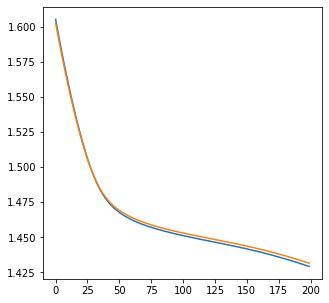

In [18]:
epoch = [i for i in range(len(train_loss))]

plt.figure(figsize=(5,5))
plt.plot(epoch, train_loss)
plt.plot(epoch, valid_loss)
plt.show()

In [19]:
Y_te = label_list
preds_te = preds_list

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

Accuracy: 0.4579045837231057
Precision: 0.30107724331273
Recall: 0.3847558563621491
F1-Score: 0.3272409860480403


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/